In [1]:
# %%
import ot
import scipy.sparse
import matplotlib
import sklearn
from matplotlib import cm
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.neighbors import NearestNeighbors

np.random.seed(42)
random.seed(42)
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, homogeneity_score, \
    completeness_score
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import harmonypy as hm
import squidpy as sq


# from scipy.spatial import *
# from sklearn.preprocessing import *
# from sklearn.metrics import *
# from scipy.spatial.distance import *


def res_search(adata, target_k=7, res_start=0.1, res_step=0.1, res_epochs=10):
    """
        adata: the Anndata object, a dataset.
        target_k: int, expected number of clusters.
        res_start: float, starting value of resolution. default: 0.1.
        res_step: float, step of resoution. default: 0.1.
        res_epochs: int, epoch of resolution. default: 10.
    """

    print(f"searching resolution to k={target_k}")
    res = res_start
    sc.tl.leiden(adata, resolution=res)

    old_k = len(adata.obs['leiden'].cat.categories)
    print("Res = ", res, "Num of clusters = ", old_k)

    run = 0
    while old_k != target_k:
        old_sign = 1 if (old_k < target_k) else -1
        sc.tl.leiden(adata, resolution=res + res_step * old_sign)
        new_k = len(adata.obs['leiden'].cat.categories)
        print("Res = ", res + res_step * old_sign, "Num of clusters = ", new_k)
        if new_k == target_k:
            res = res + res_step * old_sign
            print("recommended res = ", str(res))
            return res
        new_sign = 1 if (new_k < target_k) else -1
        if new_sign == old_sign:
            res = res + res_step * old_sign
            print("Res changed to", res)
            old_k = new_k
        else:
            res_step = res_step / 2
            print("Res changed to", res)
        if run > res_epochs:
            print("Exact resolution not found")
            print("Recommended res = ", str(res))
            return res
        run += 1
    print("Recommended res = ", str(res))
    return res


def _compute_CHAOS(clusterlabel, location):
    clusterlabel = np.array(clusterlabel)
    location = np.array(location)
    matched_location = StandardScaler().fit_transform(location)

    clusterlabel_unique = np.unique(clusterlabel)
    dist_val = np.zeros(len(clusterlabel_unique))
    count = 0
    for k in clusterlabel_unique:
        location_cluster = matched_location[clusterlabel == k, :]
        if len(location_cluster) <= 2:
            continue
        n_location_cluster = len(location_cluster)
        results = [fx_1NN(i, location_cluster) for i in range(n_location_cluster)]
        dist_val[count] = np.sum(results)
        count = count + 1

    return np.sum(dist_val) / len(clusterlabel)


def fx_1NN(i, location_in):
    location_in = np.array(location_in)
    dist_array = distance_matrix(location_in[i, :][None, :], location_in)[0, :]
    dist_array[i] = np.inf
    return np.min(dist_array)


def fx_kNN(i, location_in, k, cluster_in):
    location_in = np.array(location_in)
    cluster_in = np.array(cluster_in)

    dist_array = distance_matrix(location_in[i, :][None, :], location_in)[0, :]
    dist_array[i] = np.inf
    ind = np.argsort(dist_array)[:k]
    cluster_use = np.array(cluster_in)
    if np.sum(cluster_use[ind] != cluster_in[i]) > (k / 2):
        return 1
    else:
        return 0


def _compute_PAS(clusterlabel, location):
    clusterlabel = np.array(clusterlabel)
    location = np.array(location)
    matched_location = location
    results = [fx_kNN(i, matched_location, k=10, cluster_in=clusterlabel) for i in range(matched_location.shape[0])]
    return np.sum(results) / len(clusterlabel)


def compute_ARI(adata, gt_key, pred_key):
    return adjusted_rand_score(adata.obs[gt_key], adata.obs[pred_key])


def compute_NMI(adata, gt_key, pred_key):
    return normalized_mutual_info_score(adata.obs[gt_key], adata.obs[pred_key])


def compute_CHAOS(adata, pred_key, spatial_key='spatial'):
    return _compute_CHAOS(adata.obs[pred_key], adata.obsm[spatial_key])


def compute_PAS(adata, pred_key, spatial_key='spatial'):
    return _compute_PAS(adata.obs[pred_key], adata.obsm[spatial_key])


def compute_ASW(adata, pred_key, spatial_key='spatial'):
    d = squareform(pdist(adata.obsm[spatial_key]))
    return silhouette_score(X=d, labels=adata.obs[pred_key], metric='precomputed')


def compute_HOM(adata, gt_key, pred_key):
    return homogeneity_score(adata.obs[gt_key], adata.obs[pred_key])


def compute_COM(adata, gt_key, pred_key):
    return completeness_score(adata.obs[gt_key], adata.obs[pred_key])


import ot


def refine_label(adata, radius=50, key='label'):
    n_neigh = radius
    new_type = []
    old_type = adata.obs[key].values

    # calculate distance
    position = adata.obsm['spatial']
    distance = ot.dist(position, position, metric='euclidean')

    n_cell = distance.shape[0]

    for i in range(n_cell):
        vec = distance[i, :]
        index = vec.argsort()
        neigh_type = []
        for j in range(1, n_neigh + 1):
            neigh_type.append(old_type[index[j]])
        max_type = max(neigh_type, key=neigh_type.count)
        new_type.append(max_type)

    new_type = [str(i) for i in list(new_type)]
    # adata.obs['label_refined'] = np.array(new_type)

    return new_type


def get_metrics(adata, label_key, prediction_key):
    adata = adata[~pd.isnull(adata.obs[label_key])]
    ARI = compute_ARI(adata, label_key, prediction_key)
    NMI = compute_NMI(adata, label_key, prediction_key)
    HOM = compute_HOM(adata, label_key, prediction_key)
    COM = compute_COM(adata, label_key, prediction_key)
    CHAOS = compute_CHAOS(adata, prediction_key)
    PAS = compute_PAS(adata, prediction_key)
    return ARI, (NMI + HOM + COM) / 3, (CHAOS + PAS) / 2



def align_spots(adata_st_list_input,  # list of spatial transcriptomics datasets
                method="icp",  # "icp" or "paste"
                data_type="Visium",
                # a spot has six nearest neighborhoods if "Visium", four nearest neighborhoods otherwise
                coor_key="spatial",  # "spatial" for visium; key for the spatial coordinates used for alignment
                tol=0.01,  # parameter for "icp" method; tolerance level
                test_all_angles=False,  # parameter for "icp" method; whether to test multiple rotation angles or not
                plot=False,
                paste_alpha=0.1,
                paste_dissimilarity="kl"
                ):
    # Align coordinates of spatial transcriptomics

    # The first adata in the list is used as a reference for alignment
    adata_st_list = adata_st_list_input.copy()

    if plot:
        # Choose colors
        cmap = cm.get_cmap('rainbow', len(adata_st_list))
        colors_list = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(adata_st_list))]

        # Plot spots before alignment
        plt.figure(figsize=(5, 5))
        plt.title("Before alignment")
        for i in range(len(adata_st_list)):
            plt.scatter(adata_st_list[i].obsm[coor_key][:, 0],
                        adata_st_list[i].obsm[coor_key][:, 1],
                        c=colors_list[i],
                        label="Slice %d spots" % i, s=5., alpha=0.5)
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.xticks([])
        plt.yticks([])
        plt.legend(loc=(1.02, .2), ncol=(len(adata_st_list) // 13 + 1))
        plt.show()

    if (method == "icp") or (method == "ICP"):
        print("Using the Iterative Closest Point algorithm for alignemnt.")
        # Detect edges
        print("Detecting edges...")
        point_cloud_list = []
        for adata in adata_st_list:
            # Use in-tissue spots only
            if 'in_tissue' in adata.obs.columns:
                adata = adata[adata.obs['in_tissue'] == 1]
            if data_type == "Visium":
                loc_x = adata.obs.loc[:, ["array_row"]]
                loc_x = np.array(loc_x) * np.sqrt(3)
                loc_y = adata.obs.loc[:, ["array_col"]]
                loc_y = np.array(loc_y)
                loc = np.concatenate((loc_x, loc_y), axis=1)
                pairwise_loc_distsq = np.sum((loc.reshape([1, -1, 2]) - loc.reshape([-1, 1, 2])) ** 2, axis=2)
                n_neighbors = np.sum(pairwise_loc_distsq < 5, axis=1) - 1
                edge = ((n_neighbors > 1) & (n_neighbors < 5)).astype(np.float32)
            else:
                loc_x = adata.obs.loc[:, ["array_row"]]
                loc_x = np.array(loc_x)
                loc_y = adata.obs.loc[:, ["array_col"]]
                loc_y = np.array(loc_y)
                loc = np.concatenate((loc_x, loc_y), axis=1)
                pairwise_loc_distsq = np.sum((loc.reshape([1, -1, 2]) - loc.reshape([-1, 1, 2])) ** 2, axis=2)
                min_distsq = np.sort(np.unique(pairwise_loc_distsq), axis=None)[1]
                n_neighbors = np.sum(pairwise_loc_distsq < (min_distsq * 3), axis=1) - 1
                edge = ((n_neighbors > 1) & (n_neighbors < 7)).astype(np.float32)
            point_cloud_list.append(adata.obsm[coor_key][edge == 1].copy())

        # Align edges
        print("Aligning edges...")
        trans_list = []
        adata_st_list[0].obsm["spatial_aligned"] = adata_st_list[0].obsm[coor_key].copy()
        # Calculate pairwise transformation matrices
        for i in range(len(adata_st_list) - 1):
            if test_all_angles == True:
                for angle in [0., np.pi * 1 / 3, np.pi * 2 / 3, np.pi, np.pi * 4 / 3, np.pi * 5 / 3]:
                    R = np.array([[np.cos(angle), np.sin(angle), 0],
                                  [-np.sin(angle), np.cos(angle), 0],
                                  [0, 0, 1]]).T
                    T, distances, _ = icp(transform(point_cloud_list[i + 1], R), point_cloud_list[i], tolerance=tol)
                    if angle == 0:
                        loss_best = np.mean(distances)
                        angle_best = angle
                        R_best = R
                        T_best = T
                    else:
                        if np.mean(distances) < loss_best:
                            loss_best = np.mean(distances)
                            angle_best = angle
                            R_best = R
                            T_best = T
                T = T_best @ R_best
            else:
                T, _, _ = icp(point_cloud_list[i + 1], point_cloud_list[i], tolerance=tol)
            trans_list.append(T)
        # Tranform
        for i in range(len(adata_st_list) - 1):
            point_cloud_align = adata_st_list[i + 1].obsm[coor_key].copy()
            for T in trans_list[:(i + 1)][::-1]:
                point_cloud_align = transform(point_cloud_align, T)
            adata_st_list[i + 1].obsm["spatial_aligned"] = point_cloud_align

    elif (method == "paste") or (method == "PASTE"):
        print("Using PASTE algorithm for alignemnt.")
        # Align spots
        print("Aligning spots...")
        pis = []
        # Calculate pairwise transformation matrices
        for i in range(len(adata_st_list) - 1):
            pi = pairwise_align_paste(adata_st_list[i], adata_st_list[i + 1], coor_key=coor_key,
                                      alpha=paste_alpha, dissimilarity=paste_dissimilarity)
            pis.append(pi)
        # Tranform
        S1, S2 = generalized_procrustes_analysis(adata_st_list[0].obsm[coor_key],
                                                 adata_st_list[1].obsm[coor_key],
                                                 pis[0])
        adata_st_list[0].obsm["spatial_aligned"] = S1
        adata_st_list[1].obsm["spatial_aligned"] = S2
        for i in range(1, len(adata_st_list) - 1):
            S1, S2 = generalized_procrustes_analysis(adata_st_list[i].obsm["spatial_aligned"],
                                                     adata_st_list[i + 1].obsm[coor_key],
                                                     pis[i])
            adata_st_list[i + 1].obsm["spatial_aligned"] = S2

    if plot:
        plt.figure(figsize=(5, 5))
        plt.title("After alignment")
        for i in range(len(adata_st_list)):
            plt.scatter(adata_st_list[i].obsm["spatial_aligned"][:, 0],
                        adata_st_list[i].obsm["spatial_aligned"][:, 1],
                        c=colors_list[i],
                        label="Slice %d spots" % i, s=5., alpha=0.5)
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.xticks([])
        plt.yticks([])
        plt.legend(loc=(1.02, .2), ncol=(len(adata_st_list) // 13 + 1))
        plt.show()

    return adata_st_list


# Functions for the Iterative Closest Point algorithm
# Credit to https://github.com/ClayFlannigan/icp
def best_fit_transform(A, B):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m - 1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # homogeneous transformation
    T = np.identity(m + 1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m + 1, A.shape[0]))
    dst = np.ones((m + 1, B.shape[0]))
    src[:m, :] = np.copy(A.T)
    dst[:m, :] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m, :].T, dst[:m, :].T)

        # compute the transformation between the current source and nearest destination points
        T, _, _ = best_fit_transform(src[:m, :].T, dst[:m, indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T, _, _ = best_fit_transform(A, src[:m, :].T)

    return T, distances, i


def transform(point_cloud, T):
    point_cloud_align = np.ones((point_cloud.shape[0], 3))
    point_cloud_align[:, 0:2] = np.copy(point_cloud)
    point_cloud_align = np.dot(T, point_cloud_align.T).T
    return point_cloud_align[:, :2]


# Functions for the PASTE algorithm
# Credit to https://github.com/raphael-group/paste

## Covert a sparse matrix into a dense np array
to_dense_array = lambda X: X.toarray() if isinstance(X, scipy.sparse.csr.spmatrix) else np.array(X)

## Returns the data matrix or representation
extract_data_matrix = lambda adata, rep: adata.X if rep is None else adata.obsm[rep]


def intersect(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3


def kl_divergence_backend(X, Y):
    assert X.shape[1] == Y.shape[1], "X and Y do not have the same number of features."

    nx = ot.backend.get_backend(X, Y)

    X = X / nx.sum(X, axis=1, keepdims=True)
    Y = Y / nx.sum(Y, axis=1, keepdims=True)
    log_X = nx.log(X)
    log_Y = nx.log(Y)
    X_log_X = nx.einsum('ij,ij->i', X, log_X)
    X_log_X = nx.reshape(X_log_X, (1, X_log_X.shape[0]))
    D = X_log_X.T - nx.dot(X, log_Y.T)
    return nx.to_numpy(D)


def my_fused_gromov_wasserstein(M, C1, C2, p, q, G_init=None, loss_fun='square_loss', alpha=0.5, armijo=False,
                                log=False, numItermax=200, use_gpu=False, **kwargs):
    p, q = ot.utils.list_to_array(p, q)

    p0, q0, C10, C20, M0 = p, q, C1, C2, M
    nx = ot.backend.get_backend(p0, q0, C10, C20, M0)

    constC, hC1, hC2 = ot.gromov.init_matrix(C1, C2, p, q, loss_fun)

    if G_init is None:
        G0 = p[:, None] * q[None, :]
    else:
        G0 = (1 / nx.sum(G_init)) * G_init
        if use_gpu:
            G0 = G0.cuda()

    def f(G):
        return ot.gromov.gwloss(constC, hC1, hC2, G)

    def df(G):
        return ot.gromov.gwggrad(constC, hC1, hC2, G)

    if log:
        res, log = ot.gromov.cg(p, q, (1 - alpha) * M, alpha, f, df, G0, armijo=armijo, C1=C1, C2=C2, constC=constC,
                                log=True, **kwargs)

        fgw_dist = log['loss'][-1]

        log['fgw_dist'] = fgw_dist
        log['u'] = log['u']
        log['v'] = log['v']
        return res, log

    else:
        return ot.gromov.cg(p, q, (1 - alpha) * M, alpha, f, df, G0, armijo=armijo, C1=C1, C2=C2, constC=constC,
                            **kwargs)


def pairwise_align_paste(
        sliceA,
        sliceB,
        alpha=0.1,
        dissimilarity='kl',
        use_rep=None,
        G_init=None,
        a_distribution=None,
        b_distribution=None,
        norm=False,
        numItermax=200,
        backend=ot.backend.NumpyBackend(),
        use_gpu=False,
        return_obj=False,
        verbose=False,
        gpu_verbose=False,
        coor_key="spatial",
        **kwargs):
    if use_gpu:
        try:
            import torch
        except:
            print("We currently only have gpu support for Pytorch. Please install torch.")

        if isinstance(backend, ot.backend.TorchBackend):
            if torch.cuda.is_available():
                if gpu_verbose:
                    print("gpu is available, using gpu.")
            else:
                if gpu_verbose:
                    print("gpu is not available, resorting to torch cpu.")
                use_gpu = False
        else:
            print(
                "We currently only have gpu support for Pytorch, please set backend = ot.backend.TorchBackend(). Reverting to selected backend cpu.")
            use_gpu = False
    else:
        if gpu_verbose:
            print("Using selected backend cpu. If you want to use gpu, set use_gpu = True.")

    # subset for common genes
    common_genes = intersect(sliceA.var.index, sliceB.var.index)
    sliceA = sliceA[:, common_genes]
    sliceB = sliceB[:, common_genes]

    # Backend
    nx = backend

    # Calculate spatial distances
    coordinatesA = sliceA.obsm[coor_key].copy()
    coordinatesA = nx.from_numpy(coordinatesA)
    coordinatesB = sliceB.obsm[coor_key].copy()
    coordinatesB = nx.from_numpy(coordinatesB)

    if isinstance(nx, ot.backend.TorchBackend):
        coordinatesA = coordinatesA.float()
        coordinatesB = coordinatesB.float()
    D_A = ot.dist(coordinatesA, coordinatesA, metric='euclidean')
    D_B = ot.dist(coordinatesB, coordinatesB, metric='euclidean')

    if isinstance(nx, ot.backend.TorchBackend) and use_gpu:
        D_A = D_A.cuda()
        D_B = D_B.cuda()

    # Calculate expression dissimilarity
    A_X, B_X = nx.from_numpy(to_dense_array(extract_data_matrix(sliceA, use_rep))), nx.from_numpy(
        to_dense_array(extract_data_matrix(sliceB, use_rep)))

    if isinstance(nx, ot.backend.TorchBackend) and use_gpu:
        A_X = A_X.cuda()
        B_X = B_X.cuda()

    if dissimilarity.lower() == 'euclidean' or dissimilarity.lower() == 'euc':
        M = ot.dist(A_X, B_X)
    else:
        s_A = A_X + 0.01
        s_B = B_X + 0.01
        M = kl_divergence_backend(s_A, s_B)
        M = nx.from_numpy(M)

    if isinstance(nx, ot.backend.TorchBackend) and use_gpu:
        M = M.cuda()

    # init distributions
    if a_distribution is None:
        a = nx.ones((sliceA.shape[0],)) / sliceA.shape[0]
    else:
        a = nx.from_numpy(a_distribution)

    if b_distribution is None:
        b = nx.ones((sliceB.shape[0],)) / sliceB.shape[0]
    else:
        b = nx.from_numpy(b_distribution)

    if isinstance(nx, ot.backend.TorchBackend) and use_gpu:
        a = a.cuda()
        b = b.cuda()

    if norm:
        D_A /= nx.min(D_A[D_A > 0])
        D_B /= nx.min(D_B[D_B > 0])

    # Run OT
    if G_init is not None:
        G_init = nx.from_numpy(G_init)
        if isinstance(nx, ot.backend.TorchBackend):
            G_init = G_init.float()
            if use_gpu:
                G_init.cuda()
    pi, logw = my_fused_gromov_wasserstein(M, D_A, D_B, a, b, G_init=G_init, loss_fun='square_loss', alpha=alpha,
                                           log=True, numItermax=numItermax, verbose=verbose, use_gpu=use_gpu)
    pi = nx.to_numpy(pi)
    obj = nx.to_numpy(logw['fgw_dist'])
    if isinstance(backend, ot.backend.TorchBackend) and use_gpu:
        torch.cuda.empty_cache()

    if return_obj:
        return pi, obj
    return pi


def generalized_procrustes_analysis(X, Y, pi, output_params=False, matrix=False):
    """
    Finds and applies optimal rotation between spatial coordinates of two layers (may also do a reflection).
    Args:
        X: np array of spatial coordinates (ex: sliceA.obs['spatial'])
        Y: np array of spatial coordinates (ex: sliceB.obs['spatial'])
        pi: mapping between the two layers output by PASTE
        output_params: Boolean of whether to return rotation angle and translations along with spatial coordiantes.
        matrix: Boolean of whether to return the rotation as a matrix or an angle
    Returns:
        Aligned spatial coordinates of X, Y, rotation angle, translation of X, translation of Y
    """
    assert X.shape[1] == 2 and Y.shape[1] == 2

    tX = pi.sum(axis=1).dot(X)
    tY = pi.sum(axis=0).dot(Y)
    X = X - tX
    Y = Y - tY
    H = Y.T.dot(pi.T.dot(X))
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T.dot(U.T)
    Y = R.dot(Y.T).T
    if output_params and not matrix:
        M = np.array([[0, -1], [1, 0]])
        theta = np.arctan(np.trace(M.dot(H)) / np.trace(H))
        return X, Y, theta, tX, tY
    elif output_params and matrix:
        return X, Y, R, tX, tY
    else:
        return X, Y


# %%
import anndata as ad
import scipy.sparse
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import sklearn.neighbors
import scipy.sparse as sp
import numpy as np
import pandas as pd


def preprocess(adata_st_list,  # list of spatial transcriptomics (ST) anndata objects
               section_ids=None,
               three_dim_coor=None,  # if not None, use existing 3d coordinates in shape [# of total spots, 3]
               coor_key="spatial_aligned",  # "spatial_aligned" by default
               rad_cutoff=None,  # cutoff radius of spots for building graph
               rad_coef=1.5,  # if rad_cutoff=None, rad_cutoff is the minimum distance between spots multiplies rad_coef
               k_cutoff=12,
               slice_dist_micron=None,  # pairwise distances in micrometer for reconstructing z-axis
               c2c_dist=100,  # center to center distance between nearest spots in micrometer
               model='KNN',
               ):
    assert (model in ['Radius', 'KNN'])
    adata_st = ad.concat(adata_st_list, label="slice_name", keys=section_ids)
    adata_st.obs['Ground Truth'] = adata_st.obs['Ground Truth'].astype('category')
    adata_st.obs["batch_name"] = adata_st.obs["slice_name"].astype('category')

    # Build a graph for spots across multiple slices
    print("Start building a graph...")

    # Build 3D coordinates
    if three_dim_coor is None:
        # The first adata in adata_list is used as a reference for computing cutoff radius of spots
        adata_st_ref = adata_st_list[0].copy()
        loc_ref = np.array(adata_st_ref.obsm[coor_key])
        pair_dist_ref = pairwise_distances(loc_ref)
        min_dist_ref = np.sort(np.unique(pair_dist_ref), axis=None)[1]

        if rad_cutoff is None:
            # The radius is computed base on the attribute "adata.obsm['spatial']"
            rad_cutoff = min_dist_ref * rad_coef
        print("Radius for graph connection is %.4f." % rad_cutoff)

        # Use the attribute "adata.obsm['spatial_aligned']" to build a global graph
        if slice_dist_micron is None:
            loc_xy = pd.DataFrame(adata_st.obsm['spatial_aligned']).values
            loc_z = np.zeros(adata_st.shape[0])
            loc = np.concatenate([loc_xy, loc_z.reshape(-1, 1)], axis=1)
        else:
            if len(slice_dist_micron) != (len(adata_st_list) - 1):
                raise ValueError("The length of 'slice_dist_micron' should be the number of adatas - 1 !")
            else:
                loc_xy = pd.DataFrame(adata_st.obsm['spatial_aligned']).values
                loc_z = np.zeros(adata_st.shape[0])
                dim = 0
                for i in range(len(slice_dist_micron)):
                    dim += adata_st_list[i].shape[0]
                    loc_z[dim:] += slice_dist_micron[i] * (min_dist_ref / c2c_dist)
                loc = np.concatenate([loc_xy, loc_z.reshape(-1, 1)], axis=1)

    # If 3D coordinates already exists
    else:
        if rad_cutoff is None:
            raise ValueError("Please specify 'rad_cutoff' for finding 3D neighbors!")
        loc = three_dim_coor

    loc = pd.DataFrame(loc)
    loc.index = adata_st.obs.index
    loc.columns = ['x', 'y', 'z']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(loc)
        distances, indices = nbrs.radius_neighbors(loc, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it] * indices[it].shape[0], indices[it], distances[it])))

    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff + 1).fit(loc)
        distances, indices = nbrs.kneighbors(loc)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it] * indices.shape[1], indices[it, :], distances[it, :])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance'] > 0,]
    id_cell_trans = dict(zip(range(loc.shape[0]), np.array(loc.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)

    print('The graph contains %d edges, %d cells.' % (Spatial_Net.shape[0], adata_st.n_obs))
    print('%.4f neighbors per cell on average.' % (Spatial_Net.shape[0] / adata_st.n_obs))

    adata_st.uns['Spatial_Net'] = Spatial_Net
    return adata_st


# %%
import shutil
import warnings

warnings.filterwarnings('ignore')

import os

import torch
import SpaMask as stm
from pathlib import Path
import scanpy as sc
from sklearn import metrics
# %%
from sklearn.decomposition import PCA


def load_adata(section_ids, k_cutoff, rad_cutoff, model, n_top_genes):
    Batch_list = []
    for section_id in section_ids:
        print(section_id)
        input_dir = os.path.join('D:\\project\\datasets\\DLPFC\\', section_id)
        adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5',
                               load_images=True)
        adata.var_names_make_unique(join="++")

        # read the annotation
        Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
        Ann_df.columns = ['Ground Truth']
        Ann_df[Ann_df.isna()] = "unknown"
        adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

        # make spot name unique
        adata.obs_names = [x + '_' + section_id for x in adata.obs_names]

        # stm.Cal_Spatial_Net(adata, rad_cutoff=150)
        adata.var_names_make_unique()
        adata.layers['count'] = adata.X.toarray()
        sc.pp.filter_genes(adata, min_cells=50)
        sc.pp.filter_genes(adata, min_counts=10)
        sc.pp.normalize_total(adata, target_sum=1e6)
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=n_top_genes)
        adata = adata[:, adata.var['highly_variable'] == True]
        sc.pp.scale(adata)
        adata = adata[:, adata.var['highly_variable']]
        Batch_list.append(adata)

    # %%
    Batch_list = align_spots(Batch_list, method='icp', plot=False)
    # %%
    adata_st = preprocess(Batch_list, section_ids=section_ids, k_cutoff=k_cutoff, rad_cutoff=rad_cutoff, model=model,
                          slice_dist_micron=[10, 10, 10])
    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata_st.X)
    adata_st.obsm['feat'] = adata_X

    return adata_st


def train_one(args, adata, num_clusters):
    # %%
    net = stm.spaMask.SPAMASK(adata,
                     tissue_name='Donor',
                     num_clusters=num_clusters,
                     device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
                     learning_rate=args.learning_rate,
                     weight_decay=args.weight_decay,
                     max_epoch=args.max_epoch,
                     gradient_clipping=args.gradient_clipping,
                     feat_mask_rate=args.feat_mask_rate,
                     edge_drop_rate=args.edge_drop_rate,
                     hidden_dim=args.hidden_dim,
                     latent_dim=args.latent_dim,
                     bn=args.bn,
                     att_dropout_rate=args.att_dropout_rate,
                     fc_dropout_rate=args.fc_dropout_rate,
                     use_token=args.use_token,
                     rep_loss=args.rep_loss,
                     rel_loss=args.rel_loss,
                     alpha=args.alpha,
                     lam=args.lam,
                     random_seed=args.seed,
                     nps=args.nps)
    net.train()
    # %%
    method = "kmeans"
    net.process(method=method)
    adata = net.get_adata()
    return  adata


args = stm.utils.build_args()
args.hidden_dim, args.latent_dim = 512, 256
args.max_epoch = 1000
args.lam = 2
args.feat_mask_rate = 0.5
args.edge_drop_rate = 0.2
args.top_genes = 5000
args.rad_cutoff = 200
args.k_cutoff = 21
args.model = 'KNN'


In [2]:
slices_list = ['151673', '151674', '151675', '151676']
num_clusters = 7

adata = load_adata(slices_list, k_cutoff=args.k_cutoff, rad_cutoff=args.rad_cutoff, model=args.model,
                   n_top_genes=args.top_genes)

151673
151674
151675
151676
Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...
Start building a graph...
Radius for graph connection is 200.0000.
The graph contains 301644 edges, 14364 cells.
21.0000 neighbors per cell on average.


In [3]:
adata = train_one(args, adata, num_clusters)

(14364, 200)


Dataset_Name:Donor, Ep 999: train loss:0.3819: 100%|██████████| 1000/1000 [00:59<00:00, 16.92it/s]


In [4]:
PD_key = 'kmeans'
GT_key = 'Ground Truth'
LT_key = 'eval_pred'
BT_key = 'batch_name'

In [5]:
maps = {5:'Layer_1', 4:'Layer_2', 0:'Layer_3', 2:'Layer_4', 1:'Layer_5', 6:'Layer_6',3:'WM'}
values = [maps[value] for value in adata.obs[PD_key]]
data = {'cluster': values}
df = pd.DataFrame(data, index=adata.obs[PD_key].index)
adata.obs[PD_key] = df

[<Axes: title={'center': 'Ground Truth'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'kmeans'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batch_name'}, xlabel='UMAP1', ylabel='UMAP2'>]

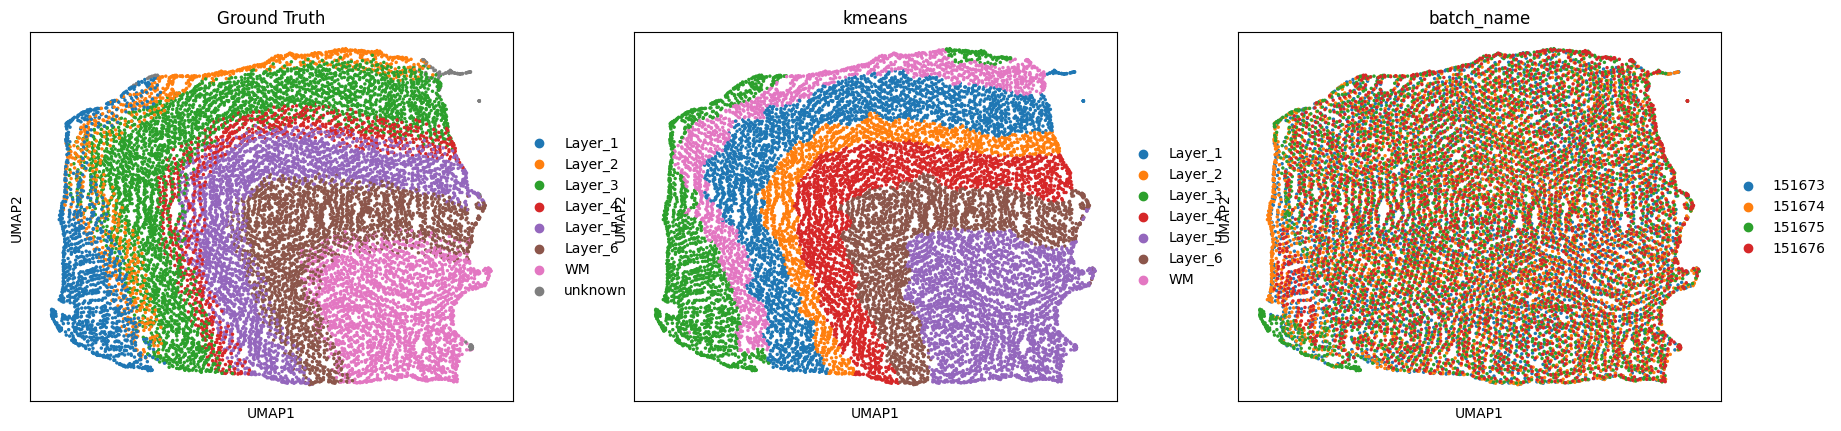

In [6]:
sc.pp.neighbors(adata, use_rep=LT_key, metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=[GT_key, PD_key, BT_key], show=False, size=25, save=False)

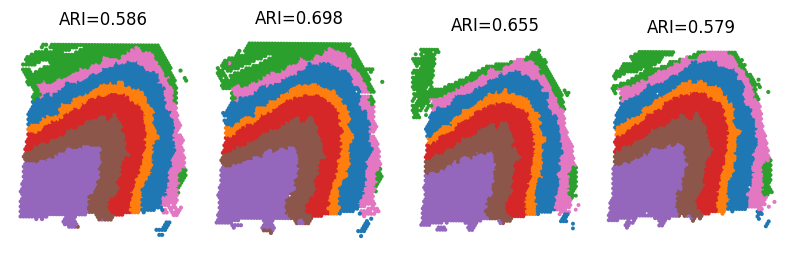

In [7]:
Batch_list = []
for section_id in slices_list:
    Batch_list.append(adata[adata.obs[BT_key] == section_id])

ARI_LIST, ACC_LIST, DIS_LIST = [], [], []
for idx in range(len(slices_list)):
    ARI,  ACC,  DIS = get_metrics(Batch_list[idx], GT_key, PD_key)
    ARI_LIST.append(round(ARI, 3))
    ACC_LIST.append(round(ACC, 3))
    DIS_LIST.append(round(DIS, 4))

spot_size = 200
title_size = 12

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(slices_list)):
    _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=[PD_key], title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                         spot_size=spot_size)
    _sc_[0].set_title("ARI=" + str(ARI_LIST[idx]), size=title_size)
plt.show()